In [2]:
###### import requests
import json
import time
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import savetxt
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy.random as rng

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D,Conv2D, ZeroPadding2D, Activation, Input, concatenate,MaxPooling1D
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K


In [3]:
# test=pd.read_pickle("data3/datanote3.pkl")
# # test["index"] = test["timestamp"]
# test.to_pickle("data5/datanote3.pkl")
# # test.columns

In [4]:
def viewAllDataFromFolder(dataPath):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    dataList = []
    for fs in onlyfiles:
        if ".pkl" in fs:
            count = count + 1
            dataItem = pd.read_pickle(dataPath+"/"+fs)
            dataItem["FileIndex"]=count
            dataList.append(dataItem)
    frame = pd.concat(dataList)
    frame = frame.reset_index().fillna(0)
#     frame["node"] = frame["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
    return (frame,count)

In [5]:
(dataset,filecount) = viewAllDataFromFolder("data5")

In [6]:
dataset

,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,disk_io,disk_space_used,net_received,net_transmit,node,label,FileIndex
0,1.635424e+09,0.096667,0.486000,0.392667,0.000000,13.0,20.68,3.016884e+09,1.069158e+09,0.001067,0.632746,5.048843e+05,330717.866667,tan-km,1,1
1,1.635424e+09,0.079667,0.519333,0.372000,0.002000,13.0,16.10,3.016802e+09,1.069240e+09,0.020800,0.632747,5.986763e+05,285288.533333,tan-km,1,1
2,1.635424e+09,0.079667,0.519333,0.372000,0.002000,13.0,16.10,3.016802e+09,1.069240e+09,0.020800,0.632747,5.986763e+05,285288.533333,tan-km,1,1
3,1.635424e+09,0.106333,0.457000,0.398000,0.010333,13.0,12.85,3.017253e+09,1.068790e+09,0.124000,0.632749,5.447525e+05,345348.800000,tan-km,1,1
4,1.635424e+09,0.106333,0.457000,0.398000,0.010333,13.0,12.85,3.017253e+09,1.068790e+09,0.124000,0.632749,5.447525e+05,345348.800000,tan-km,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103092,1.635319e+09,0.045667,0.703667,0.207333,0.017333,6.0,7.68,2.459009e+09,1.627046e+09,0.064800,0.499278,1.644654e+06,414978.666667,tan-k3,1,15
103093,1.635319e+09,0.046000,0.638000,0.274333,0.011000,6.0,6.21,2.455822e+09,1.630233e+09,0.068800,0.498767,5.079147e+06,598870.400000,tan-k3,1,15
103094,1.635319e+09,0.046000,0.638000,0.274333,0.011000,6.0,6.21,2.455822e+09,1.630233e+09,0.068800,0.498767,5.079147e+06,598870.400000,tan-k3,1,15
103095,1.635319e+09,0.035333,0.752667,0.181333,0.001333,6.0,4.83,2.443833e+09,1.642222e+09,0.004533,0.499037,6.450272e+05,401076.800000,tan-k3,1,15


In [ ]:
# dataset[dataset["node"] == "tan-k2"]["timestamp"].value_counts()

In [ ]:
# dataset[dataset["node"] == "tan-k3"].to_excel("output.xlsx")  

In [ ]:
# dataset[dataset["node"] == "tan-k3"]["cpu_system"].sort_values(by=['timestamp']).plot()

In [7]:
dataset = dataset.fillna(0)
# dataset['timestamp'] = dataset['index']
dataset["timemm"] = dataset['timestamp']
dataset['timemm'] = dataset['timemm'].apply(lambda x: datetime.fromtimestamp(x))
dataset["year"] = dataset['timemm'].apply(lambda x:x.year)
dataset["month"] = dataset['timemm'].apply(lambda x:x.month)
dataset["day"] = dataset['timemm'].apply(lambda x:x.day)
dataset["hour"] = dataset['timemm'].apply(lambda x:x.hour)
dataset["minute"] = dataset['timemm'].apply(lambda x:x.minute)
dataset["second"] = dataset['timemm'].apply(lambda x:x.second)
del dataset['timemm']

dataset["node"] = dataset["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
dataset["cpu_total"] = 1 - dataset["cpu_idle"]

dataset["cpu_user_rate"] = dataset["cpu_user"] / dataset["cpu_total"]
dataset["cpu_system_rate"] = dataset["cpu_system"] / dataset["cpu_total"]

dataset["mem_used"] = dataset["mem_total"]
dataset["mem_total"] = dataset["mem_used"] + dataset["mem_avail"]

# dataset["mem_used_rate"] = dataset["mem_used"] / dataset["mem_total"]
# dataset["mem_avail_rate"] = dataset["mem_avail"] / dataset["mem_total"]



In [8]:
dataset[dataset["node"] == 2]

,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,disk_io,...,year,month,day,hour,minute,second,cpu_total,cpu_user_rate,cpu_system_rate,mem_used
26452,1.635405e+09,0.038333,0.847667,0.100333,0.004000,8.0,2.25,4.086043e+09,1.961869e+09,0.012533,...,2021,10,28,7,16,0,0.152333,0.658643,0.251641,2.124173e+09
26453,1.635405e+09,0.038333,0.847667,0.100333,0.004000,8.0,2.25,4.086043e+09,1.961869e+09,0.012533,...,2021,10,28,7,16,8,0.152333,0.658643,0.251641,2.124173e+09
26454,1.635405e+09,0.043000,0.837667,0.093333,0.000333,8.0,2.04,4.086043e+09,1.962701e+09,0.001333,...,2021,10,28,7,16,16,0.162333,0.574949,0.264887,2.123342e+09
26455,1.635405e+09,0.043000,0.837667,0.093333,0.000333,8.0,2.04,4.086043e+09,1.962701e+09,0.001333,...,2021,10,28,7,16,24,0.162333,0.574949,0.264887,2.123342e+09
26456,1.635405e+09,0.037333,0.843000,0.109000,0.002000,8.0,1.88,4.086043e+09,1.962025e+09,0.009600,...,2021,10,28,7,16,32,0.157000,0.694268,0.237792,2.124018e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85878,1.635405e+09,0.049000,0.811000,0.116000,0.002667,8.0,2.28,4.086043e+09,1.960813e+09,0.018400,...,2021,10,28,7,15,28,0.189000,0.613757,0.259259,2.125230e+09
85879,1.635405e+09,0.049000,0.811000,0.116000,0.002667,8.0,2.28,4.086043e+09,1.960813e+09,0.018400,...,2021,10,28,7,15,36,0.189000,0.613757,0.259259,2.125230e+09
85880,1.635405e+09,0.050333,0.828333,0.105667,0.000000,8.0,2.61,4.086043e+09,1.961034e+09,0.000800,...,2021,10,28,7,15,44,0.171667,0.615534,0.293204,2.125009e+09
85881,1.635405e+09,0.050333,0.828333,0.105667,0.000000,8.0,2.61,4.086043e+09,1.961034e+09,0.000800,...,2021,10,28,7,15,52,0.171667,0.615534,0.293204,2.125009e+09


In [ ]:
# dataset[dataset["node"] == 2]["timestamp"].value_counts()

In [ ]:
# dataset[dataset["node"] == 3].sort_values(by=['timestamp']).set_index(["timestamp"])["cpu_system"].plot()

In [9]:
dataset["label"]=1

In [10]:
maliciousList3 = pd.read_csv('data5/malicious3.csv')

In [ ]:
# maliciousList

In [11]:
for index, row in maliciousList3.iterrows():
    print(row['start'], row['end'])
#     dataset["label"] = (dataset["timestamp"] >= row['start'] and dataset["timestamp"] <= row['end'] )
    dataset.loc[(dataset["timestamp"] >= row['start']) & (dataset["timestamp"] <= row['end']) & (dataset["node"]==3), 'label'] = 0
#     dataset["label"] = dataset["timestamp"].apply(lambda x : 2 if x

dataset[(dataset["node"] == 3)]["label"].value_counts()

1635079051 1635081140
1635085029 1635087126
1635090838 1635092524
1635096464 1635098577
1635102639 1635104318
1635108364 1635110122
1635113812 1635116081
1635119889 1635121235
1635125031 1635126246
1635130008 1635132012
1635135920 1635137379
1635140984 1635142363
1635146410 1635148137
1635149186 1635150635
1635154269 1635155399
1635159578 1635161783
1635165616 1635167350
1635169684 1635170884
1635174679 1635176955
1635180895 1635182437
1635186243 1635188440
1635192327 1635194122
1635197885 1635199779
1635203563 1635205639
1635209670 1635211193
1635214806 1635216793
1635220826 1635222407
1635226031 1635228010
1635231940 1635233834
1635237575 1635238875
1635242775 1635244782
1635248400 1635250245
1635254353 1635255937
1635259605 1635261750
1635265744 1635267080
1635271236 1635272603
1635276271 1635277472
1635281612 1635282859
1635286694 1635288477
1635292249 1635293778
1635297677 1635299116
1635303016 1635305039
1635308921 1635310387
1635314064 1635315896
1635319586 1635320848
1635324520

1    22832
0    11534
Name: label, dtype: int64

In [ ]:
# dataset[(dataset["node"]==2)]

In [12]:
maliciousList2 = pd.read_csv('data5/malicious2.csv')

for index, row in maliciousList2.iterrows():
    print(row['start'], row['end'])
#     dataset["label"] = (dataset["timestamp"] >= row['start'] and dataset["timestamp"] <= row['end'] )
    dataset.loc[(dataset["timestamp"] >= row['start']) & (dataset["timestamp"] <= row['end']) & (dataset["node"]==2), 'label'] = 0
#     dataset["label"] = dataset["timestamp"].apply(lambda x : 2 if x

dataset[(dataset["node"] == 2)]["label"].value_counts()

1635169678 1635170830
1635174581 1635176122
1635180184 1635182092
1635185951 1635188052
1635192047 1635193446
1635197511 1635198845
1635202793 1635204646
1635208375 1635210227
1635213996 1635215508
1635219277 1635220406
1635224433 1635225947
1635229879 1635231921
1635235880 1635237942
1635241827 1635243891
1635247575 1635249502
1635253357 1635255686
1635259535 1635261676
1635265604 1635267437
1635271492 1635273096
1635277088 1635278526
1635282189 1635283458
1635287273 1635288938
1635292582 1635294308
1635298308 1635299650
1635303481 1635304797
1635308477 1635310262
1635313941 1635315073
1635318742 1635320500
1635324331 1635325680
1635329761 1635331281
1635335099 1635336517
1635340238 1635341797
1635345763 1635347615
1635351800 1635354116
1635357799 1635359057
1635363082 1635365045
1635368825 1635370945
1635374833 1635376878
1635380596 1635381772
1635385682 1635387614
1635391224 1635392967
1635397147 1635398808
1635402713 1635403920
1635407778 1635409347
1635413016 1635415146
1635419100

1    22900
0    11466
Name: label, dtype: int64

In [13]:
dataset["label"].value_counts()

1    80097
0    23000
Name: label, dtype: int64

In [ ]:
dataset

<AxesSubplot:xlabel='timestamp'>

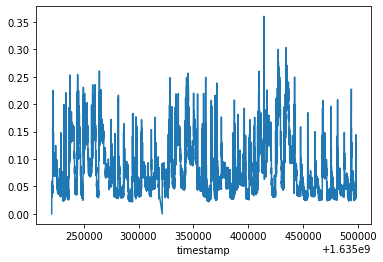

In [14]:
dataset[dataset["node"] == 3].sort_values(by=['timestamp']).set_index(["timestamp"])["cpu_system"].plot()

In [15]:
dataset[dataset["node"] == 3]["day"].value_counts()

28    10802
27    10468
26     9000
29     4096
Name: day, dtype: int64

In [16]:
def plotColor(dataset, node, metric,startTime,endTime, ax,locX,locY):
#     node=3
#     metric = "cpu_system"
    refDataset = dataset[(dataset["node"] == node) & (dataset["timestamp"]>=startTime) & (dataset["timestamp"]<=endTime) ].copy()
    refDataset = refDataset.sort_values(by=['timestamp']).set_index(["timestamp"])
    df = refDataset[[metric,"label"]]
    df["label"] = df["label"].apply(lambda x : -1 if x==0 else 1)
    def plot_func(group):
    #     print(group['cpu_system'])
#         global ax
#         global locX
#         global locY
        color = 'r' if (group['label'] < 0).all() else 'g'
        lw = 1.0
        ax[locX,locY].plot(group.index, group[metric], c=color, linewidth=lw)

    df.groupby((df['label'].shift() * df['label'] < 0).cumsum()).apply(plot_func)
    ax[locX,locY].set_title(metric)

# add ma lines
# ax.plot(df.index, df['cpu_system'], 'k--', label='MA-50')
# ax.plot(df.index, df['200dma'], 'b--', label='MA-200')
# ax.legend(loc='best')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

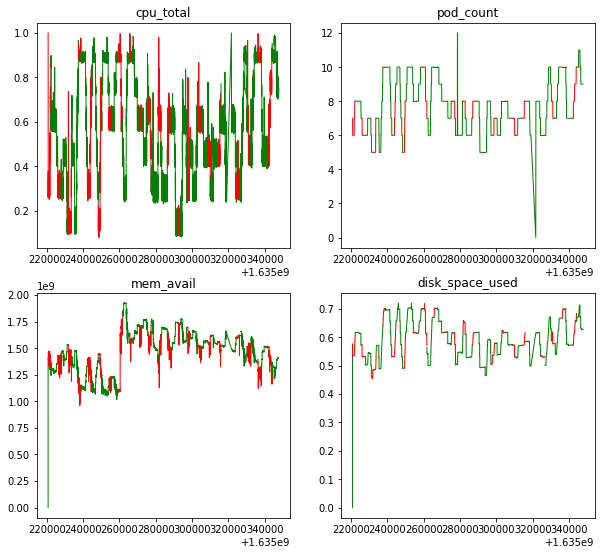

In [17]:
node=3
startTime = 1635169684
endTime = 1635347615
metricLs = ["cpu_total","pod_count","mem_avail","disk_space_used"]
divident = 2
xlen = len(metricLs)

xc = xlen % divident
if xc > 0 :
    xc = int(xlen / divident) + 1
else :
    xc = int(xlen / divident)
yc = divident
    
fig, axs = plt.subplots(xc, yc)
plt.subplots_adjust(top=1.5,wspace=0.2,hspace=0.2)
fig.set_size_inches(10, 5, forward=True)

for i in range(0,xlen):
    locX = int(i/divident)
    locY = i%divident
    plotColor(dataset, node, metricLs[i],startTime,endTime, axs, locX,locY)
# plotColor(dataset, node, "cpu_total",startTime,endTime, axs, 0,1)

In [ ]:
# dataset[(dataset["node"] == 3) & (dataset["timestamp"]>=1634746983) & (dataset["timestamp"]<=1634749479) ].to_excel("output.xlsx")

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # simulate data
# # =============================
# np.random.seed(1234)
# df = pd.DataFrame({'px_last': 100 + np.random.randn(1000).cumsum()}, index=pd.date_range('2010-01-01', periods=1000, freq='B'))


# df['50dma'] = df['px_last'].rolling(50).mean()
# df['200dma'] = df['px_last'].rolling(200).mean()

# df['label'] = np.where(df['50dma'] > df['200dma'], 1, -1)


# # plot
# # =============================
# df = df.dropna(axis=0, how='any')

# fig, ax = plt.subplots()

# def plot_func(group):
#     global ax
#     color = 'r' if (group['label'] < 0).all() else 'g'
#     lw = 2.0
#     ax.plot(group.index, group.px_last, c=color, linewidth=lw)

# df.groupby((df['label'].shift() * df['label'] < 0).cumsum()).apply(plot_func)

# # add ma lines
# # ax.plot(df.index, df['50dma'], 'k--', label='MA-50')
# # ax.plot(df.index, df['200dma'], 'b--', label='MA-200')
# # ax.legend(loc='best')

In [18]:
dataTest = dataset[(dataset["node"] == 3) ].sort_values(by=['timestamp'])
difference = dataTest["timestamp"].diff(periods=-1)
difference.value_counts()

-8.0       34361
 0.0           3
-2660.0        1
Name: timestamp, dtype: int64

In [19]:
dataTest["label"].value_counts()

1    22832
0    11534
Name: label, dtype: int64

In [ ]:
# import seaborn as sn
# plt.figure(figsize=(20,20))
# sn.heatmap(dataTest.corr(), annot=True, fmt='.2f')

In [ ]:
# node=3
# startTime = 1635078609 #Sunday, 24 October 2021 14:30:09 GMT+02:00 DST
# endTime = 1635168420 #Monday, 25 October 2021 15:27:00 GMT+02:00 DST #Last
# dataTest = dataset[(dataset["node"] == node) & (dataset["timestamp"]>=startTime) & (dataset["timestamp"]<=endTime) ].sort_values(by=['timestamp']).copy()
# dataTest.to_pickle("data3/datanote3.pkl")

In [20]:
node=2
startTime = 1635078609 #Sunday, 24 October 2021 14:30:09 GMT+02:00 DST
endTime = 1635423960 #Thursday, 28 October 2021 14:26:00 GMT+02:00 DTS #Last
dataTest = dataset[(dataset["node"] == node) & (dataset["timestamp"]>=startTime) & (dataset["timestamp"]<=endTime) ].sort_values(by=['timestamp']).copy()

# difference = dataTest["timestamp"].diff(periods=-1)
# difference.value_counts()

dataToRun = dataTest[['cpu_system','cpu_idle','cpu_user','cpu_iowait','pod_count','system_load','mem_avail','disk_io','disk_space_used','net_received','net_transmit','year','month','day','hour','minute','second','cpu_total','cpu_user_rate','cpu_system_rate','mem_used','label']].copy()
dataToRun["label"].value_counts()

1    17520
0     7546
Name: label, dtype: int64

In [21]:
dataset[(dataset["node"] == 2)]["label"].value_counts()

1    22900
0    11466
Name: label, dtype: int64

In [25]:
# node=3
# startTime = 1635078609 #Sunday, 24 October 2021 14:30:09 GMT+02:00 DST
# endTime = 1635423960 #Thursday, 28 October 2021 14:26:00 GMT+02:00 DTS #Last
# dataTest = dataset[(dataset["node"] == node) & (dataset["timestamp"]>=startTime) & (dataset["timestamp"]<=endTime) ].sort_values(by=['timestamp']).copy()

# # difference = dataTest["timestamp"].diff(periods=-1)
# # difference.value_counts()

dataToRun = dataset[['cpu_system','cpu_idle','cpu_user','cpu_iowait','pod_count','system_load','mem_avail','disk_io','disk_space_used','net_received','net_transmit','year','month','day','hour','minute','second','cpu_total','cpu_user_rate','cpu_system_rate','mem_used','label']].copy()
dataToRun["label"].value_counts()

# test=pd.read_pickle("data3/datanote3.pkl")
# # test["index"] = test["timestamp"]
dataToRun.to_pickle("tmp/datanote5.pkl")


In [27]:
# dataToRun=pd.read_pickle("tmp/datanote5.pkl")

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost

In [28]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

def normalizeColumn(datas, colStart, colEnd):
    datas2 = datas.copy()
    cols = datas2.columns
    for e in range(colStart,colEnd):
        print(e," ",cols[e])
        normalized_df=(datas2[cols[e]]-datas2[cols[e]].mean())/datas2[cols[e]].std()
        datas2[cols[e]] = normalized_df
    return datas2

In [29]:
rsDataset = resampleData(dataToRun, "label")

In [5]:
# rsDataset=pd.read_pickle("tmp/rsDataset.pkl")
# rsDataset.to_pickle("tmp/rsDataset.pkl")


In [7]:
def splitDataSetSKLearn(datasetnorms, testSplitPercent):
    dataAllX = datasetnorms.drop("label", axis=1)
    dataAllY = datasetnorms["label"]
    X_train, X_test, y_train, y_test = train_test_split(dataAllX, dataAllY, test_size=testSplitPercent)
    print("splitDataSet with sklearn")
    print("Train")
    print(X_train.shape)
    print("Train labels")
    print(y_train.value_counts())
    print("Test")
    print(X_test.shape)
    print("Test labels")
    print(y_test.value_counts())
    print("All")
    print(dataAllX.shape)
    return (dataAllX,dataAllY,X_train,y_train,X_test,y_test)
# splitDataSetSKLearn(nDatasetNormKnn,70)

In [10]:
(dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(rsDataset, 0.2)

splitDataSet with sklearn
Train
(128155, 21)
Train labels
1    64101
0    64054
Name: label, dtype: int64
Test
(32039, 21)
Test labels
0    16043
1    15996
Name: label, dtype: int64
All
(160194, 21)


# XGBoost

In [349]:
# dataTrainMX

In [340]:
# dataTestMX

In [44]:
modelXGboost = xgboost.XGBRFClassifier(n_estimators=100,objective='binary:logistic')
modelXGboost.fit(dataTrainMX.to_numpy(), dataTrainMY.to_numpy())

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:14] WARNING: /tmp/pip-build-5iihhz2k/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=6, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [45]:
y_pred = modelXGboost.predict(dataTestMX.to_numpy())
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))

Accuracy score: 0.8196260807141297


In [46]:
featureList = list(dataTrainMX.columns.values)
featureList

['cpu_system',
 'cpu_idle',
 'cpu_user',
 'cpu_iowait',
 'pod_count',
 'system_load',
 'mem_avail',
 'disk_io',
 'disk_space_used',
 'net_received',
 'net_transmit',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'cpu_total',
 'cpu_user_rate',
 'cpu_system_rate',
 'mem_used']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

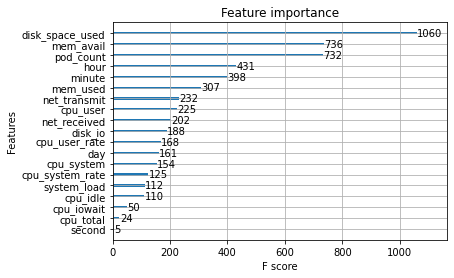

In [47]:
modelXGboost.get_booster().feature_names = featureList
xgboost.plot_importance(modelXGboost.get_booster())

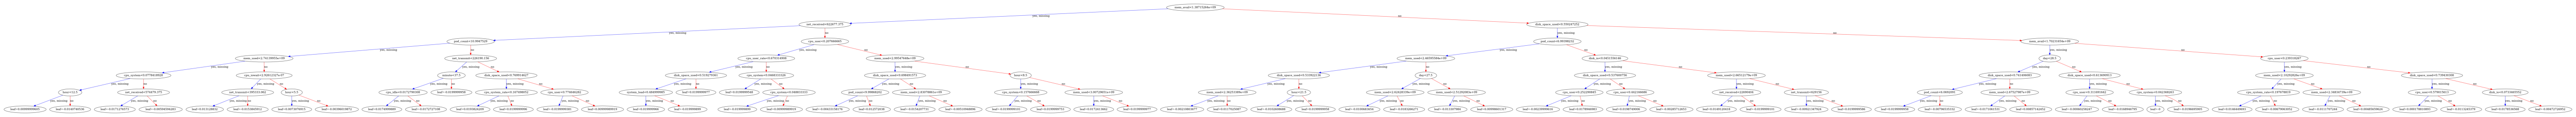

In [48]:
fig, ax = plt.subplots(figsize=(100, 100))
xgboost.plot_tree(modelXGboost, num_trees=10, ax=ax)
plt.show()

# XGBoost KFold

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute

In [51]:
dataAllX = rsDataset.drop("label", axis=1)
dataAllY = rsDataset["label"]

In [55]:
start_time = time.time()
modelXGboost = xgboost.XGBRFClassifier(n_estimators=100,objective='binary:logistic')

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(modelXGboost, dataAllX, dataAllY, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
# force scores to be positive
print("XGBoost Training Time:",(time.time() - start_time))
timeXGBoost = time.time() - start_time

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


XGBoost Training Time: 588.4536147117615


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.8min finished


In [56]:
scores = absolute(scores)
print('Mean score: %.3f (%.3f)' % (scores.mean(), scores.std()) )
scoresXGBoostMean = scores.mean()

Mean score: 0.828 (0.007)


# KNN

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from sklearn.model_selection import cross_val_score

In [12]:
from sklearn.neighbors import KNeighborsClassifier
modelKNN = KNeighborsClassifier(n_neighbors=3)
modelKNN.fit(dataTrainMX, dataTrainMY)
# KNeighborsClassifier(...)
# print(neigh.predict([[1.1]]))

KNeighborsClassifier(n_neighbors=3)

In [13]:
y_pred = modelKNN.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))

Accuracy score: 0.9060832110864884


In [15]:
start_time = time.time()
modelKNN = KNeighborsClassifier(n_neighbors=3)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresKNN = cross_val_score(modelKNN, dataTrainM, dataTestM, scoring='accuracy', cv=cv, n_jobs=-1)
# force scores to be positive
print("KNN Training Time:",(time.time() - start_time))
timeKNN = time.time() - start_time

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [100]:
scoresKNN = absolute(scoresKNN)
print('Mean SVM MAE: %.3f (%.3f)' % (scoresKNN.mean(), scoresKNN.std()) )
scoresKNNMean = scoresKNN.mean()

Mean SVM MAE: 0.822 (0.008)


# ANN

In [117]:
rsDataset

,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_avail,disk_io,disk_space_used,net_received,...,month,day,hour,minute,second,cpu_total,cpu_user_rate,cpu_system_rate,mem_used,label
0,0.072333,0.508000,0.381000,0.010000,7.0,5.170000,1.845711e+09,0.162133,0.534113,1.368198e+06,...,10,28,7,16,0,0.492000,0.774390,0.147019,2.240344e+09,1
1,0.072333,0.508000,0.381000,0.010000,7.0,5.170000,1.845711e+09,0.162133,0.534113,1.368198e+06,...,10,28,7,16,8,0.492000,0.774390,0.147019,2.240344e+09,1
2,0.084000,0.571000,0.308667,0.005333,7.0,4.020000,1.857180e+09,0.118133,0.536487,6.215904e+05,...,10,28,7,16,16,0.429000,0.719503,0.195804,2.228875e+09,1
3,0.084000,0.571000,0.308667,0.005333,7.0,4.020000,1.857180e+09,0.118133,0.536487,6.215904e+05,...,10,28,7,16,24,0.429000,0.719503,0.195804,2.228875e+09,1
4,0.089000,0.546000,0.342667,0.003000,7.0,3.130000,1.835069e+09,0.080533,0.538856,8.486059e+05,...,10,28,7,16,32,0.454000,0.754772,0.196035,2.250985e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120069,0.150353,0.096346,0.736432,0.000000,10.0,223.000000,1.359684e+09,0.027204,0.835262,4.821374e+05,...,10,28,11,34,0,0.903654,0.814949,0.166384,2.726371e+09,0
120070,0.117054,0.260149,0.552277,0.012564,8.0,34.729766,1.724656e+09,0.153515,0.616980,6.102140e+05,...,10,28,6,35,21,0.739851,0.751899,0.156891,2.361399e+09,0
120071,0.044689,0.885211,0.055592,0.000443,8.0,0.189724,2.012698e+09,0.001098,0.570171,1.438293e+06,...,10,27,19,46,44,0.114789,0.484131,0.389533,2.073345e+09,0
120072,0.113859,0.248340,0.616124,0.000222,12.0,76.302436,1.753981e+09,0.003731,0.738454,8.680941e+06,...,10,26,16,52,41,0.751660,0.819721,0.151392,2.332062e+09,0


In [118]:
normData = normalizeColumn(rsDataset,0,21)
normData= normData.fillna(0)
normData
# (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(rsDataset, 0.3)


0   cpu_system
1   cpu_idle
2   cpu_user
3   cpu_iowait
4   pod_count
5   system_load
6   mem_avail
7   disk_io
8   disk_space_used
9   net_received
10   net_transmit
11   year
12   month
13   day
14   hour
15   minute
16   second
17   cpu_total
18   cpu_user_rate
19   cpu_system_rate
20   mem_used


,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_avail,disk_io,disk_space_used,net_received,...,month,day,hour,minute,second,cpu_total,cpu_user_rate,cpu_system_rate,mem_used,label
0,-0.212394,-0.190580,0.245200,-0.009315,-0.954498,-0.543111,0.792034,0.395737,-0.947702,-0.173066,...,0.0,1.581279,-0.609196,-0.770111,-1.692885,0.190580,0.536847,-0.685286,-0.760875,1
1,-0.212394,-0.190580,0.245200,-0.009315,-0.954498,-0.543111,0.792034,0.395737,-0.947702,-0.173066,...,0.0,1.581279,-0.609196,-0.770111,-1.206584,0.190580,0.536847,-0.685286,-0.760875,1
2,0.020461,0.059799,-0.097761,-0.137805,-0.954498,-0.564488,0.829033,0.194627,-0.916269,-0.303927,...,0.0,1.581279,-0.609196,-0.770111,-0.720284,-0.059799,0.122810,-0.163642,-0.797107,1
3,0.020461,0.059799,-0.097761,-0.137805,-0.954498,-0.564488,0.829033,0.194627,-0.916269,-0.303927,...,0.0,1.581279,-0.609196,-0.770111,-0.233984,-0.059799,0.122810,-0.163642,-0.797107,1
4,0.120257,-0.039558,0.063447,-0.202050,-0.954498,-0.581031,0.757705,0.022770,-0.884905,-0.264137,...,0.0,1.581279,-0.609196,-0.770111,0.252317,0.039558,0.388863,-0.161172,-0.727257,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120069,1.344813,-1.826601,1.930446,-0.284651,0.308135,3.506043,-0.775890,-0.220982,3.039553,-0.328369,...,0.0,1.581279,0.011612,0.291937,-1.692885,1.826601,0.842795,-0.478224,0.774568,0
120070,0.680184,-1.175603,1.057293,0.061281,-0.533621,0.006364,0.401513,0.356344,0.149472,-0.305921,...,0.0,1.581279,-0.764398,0.350939,-0.416346,1.175603,0.367190,-0.579730,-0.378443,0
120071,-0.764158,1.308556,-1.297692,-0.272456,-0.533621,-0.635687,1.330734,-0.340302,-0.470287,-0.160780,...,0.0,0.229791,1.253228,0.999968,0.981767,-1.308556,-1.652682,1.907837,-1.288453,0
120072,0.616418,-1.222536,1.360018,-0.278541,1.149890,0.779141,0.496113,-0.328268,1.757794,1.108665,...,0.0,-1.121696,0.787622,1.353984,0.799405,1.222536,0.878790,-0.638529,-0.471123,0


In [119]:
# list(rsDataset.columns.values)
(dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(normData, 0.3)

splitDataSet with sklearn
Train
(84051, 21)
Train labels
0    42030
1    42021
Name: label, dtype: int64
Test
(36023, 21)
Test labels
1    18016
0    18007
Name: label, dtype: int64
All
(120074, 21)


In [120]:
X_train_ann = dataTrainMX.to_numpy().reshape((dataTrainMX.shape[0],dataTrainMX.shape[1],1))
X_test_ann = dataTestMX.to_numpy().reshape((dataTestMX.shape[0],dataTestMX.shape[1],1))
Y_train_ann = dataTrainMY.to_numpy().reshape((dataTrainMY.shape[0],1))
Y_test_ann = dataTestMY.to_numpy().reshape((dataTestMY.shape[0],1))
print("Data Shape:",X_train_ann.shape," ",Y_train_ann.shape)

Data Shape: (84051, 21, 1)   (84051, 1)


In [121]:
modelANN = keras.Sequential()
modelANN.add(Dense(units=10,input_shape=(X_train_ann.shape[1],X_train_ann.shape[2]),activation='relu'))  
modelANN.add(Dense(units=5,activation='sigmoid')) 
modelANN.add(Dense(units=3,activation='sigmoid')) 
modelANN.add(keras.layers.Flatten())
modelANN.add(Dense(units=30, activation='sigmoid')) #output layer   
modelANN.add(Dense(units=1, activation='sigmoid')) #output layer   

In [122]:
modelANN.summary()
# keras.utils.plot_model(model, "ann.png", show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21, 10)            20        
_________________________________________________________________
dense_1 (Dense)              (None, 21, 5)             55        
_________________________________________________________________
dense_2 (Dense)              (None, 21, 3)             18        
_________________________________________________________________
flatten (Flatten)            (None, 63)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1920      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 2,044
Trainable params: 2,044
Non-trainable params: 0
______________________________________________________

In [123]:
# model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['accuracy'])
start_time = time.time()

# modelANN.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
modelANN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = modelANN.fit(X_train_ann, Y_train_ann, epochs=300, validation_split = 0.2)

print("ANN Training Time:",(time.time() - start_time))

Epoch 1/300
2102/2102 [==============================] - 4s 2ms/step - loss: 0.5834 - accuracy: 0.6544 - val_loss: 0.5351 - val_accuracy: 0.6996
Epoch 2/300
2102/2102 [==============================] - 3s 2ms/step - loss: 0.5226 - accuracy: 0.7068 - val_loss: 0.5145 - val_accuracy: 0.7155
Epoch 3/300
2102/2102 [==============================] - 3s 2ms/step - loss: 0.5040 - accuracy: 0.7220 - val_loss: 0.4985 - val_accuracy: 0.7328
Epoch 4/300
2102/2102 [==============================] - 3s 2ms/step - loss: 0.4881 - accuracy: 0.7381 - val_loss: 0.4818 - val_accuracy: 0.7472
Epoch 5/300
2102/2102 [==============================] - 3s 2ms/step - loss: 0.4748 - accuracy: 0.7546 - val_loss: 0.4684 - val_accuracy: 0.7553
Epoch 6/300
2102/2102 [==============================] - 3s 2ms/step - loss: 0.4593 - accuracy: 0.7721 - val_loss: 0.4497 - val_accuracy: 0.7840
Epoch 7/300
2102/2102 [==============================] - 3s 2ms/step - loss: 0.4467 - accuracy: 0.7815 - val_loss: 0.4398 - val_ac

KeyboardInterrupt: 

In [168]:
y_pred = modelANN.predict(X_test_ann)

In [174]:
y_pred = np.where(y_pred >= 0.5, 1, 0)

In [176]:
print("Accuracy score:",accuracy_score(Y_test_ann, y_pred))

Accuracy score: 0.9298941798941799


In [158]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


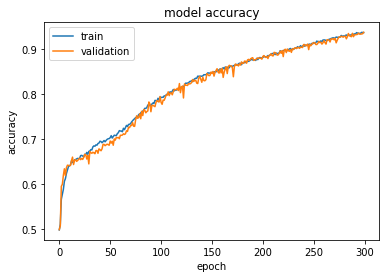

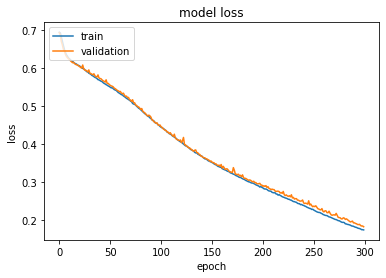

In [159]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [178]:
dataAllX = normData.drop("label", axis=1)
dataAllY = normData["label"]

dataAllX_ann = dataAllX.to_numpy().reshape((dataAllX.shape[0],dataAllX.shape[1],1))
dataAllY_ann = dataAllY.to_numpy().reshape((dataAllY.shape[0],1))

In [189]:
# n_split = 10
# for train_index,test_index in KFold(n_split).split(dataAllX_ann):
#     x_train,x_test=dataAllX_ann[train_index],dataAllX_ann[test_index]
#     y_train,y_test=dataAllX_ann[train_index],dataAllX_ann[test_index]

In [184]:
# dataAllY_ann

In [191]:
start_time = time.time()

kfold = KFold(n_splits=10, shuffle=True)
lsAnnAcc = []

for train_index,test_index in kfold.split(dataAllX_ann):
    x_train,x_test=dataAllX_ann[train_index],dataAllX_ann[test_index]
    y_train,y_test=dataAllY_ann[train_index],dataAllY_ann[test_index]
    
    modelANN = keras.Sequential()
    modelANN.add(Dense(units=10,input_shape=(dataAllX_ann.shape[1],dataAllX_ann.shape[2]),activation='relu'))  
    modelANN.add(Dense(units=5,activation='sigmoid')) 
    modelANN.add(Dense(units=3,activation='sigmoid')) 
    modelANN.add(keras.layers.Flatten())
    modelANN.add(Dense(units=30, activation='sigmoid')) #output layer   
    modelANN.add(Dense(units=1, activation='sigmoid')) #output layer   
    modelANN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = modelANN.fit(x_train, y_train, epochs=300, validation_split = 0.2)

    y_pred = modelANN.predict(x_test)
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy score:",acc)
    
    lsAnnAcc.append(acc)
    
print("ANN Training Time:",(time.time() - start_time))
timeANN = time.time() - start_time

Epoch 1/300
341/341 [==============================] - 1s 2ms/step - loss: 0.6661 - accuracy: 0.6168 - val_loss: 0.9529 - val_accuracy: 0.0000e+00
Epoch 2/300
341/341 [==============================] - 1s 2ms/step - loss: 0.6549 - accuracy: 0.6256 - val_loss: 0.9079 - val_accuracy: 0.0000e+00
Epoch 3/300
341/341 [==============================] - 1s 2ms/step - loss: 0.6474 - accuracy: 0.6252 - val_loss: 0.9081 - val_accuracy: 0.0000e+00
Epoch 4/300
341/341 [==============================] - 1s 2ms/step - loss: 0.6429 - accuracy: 0.6188 - val_loss: 0.8973 - val_accuracy: 3.6738e-04
Epoch 5/300
341/341 [==============================] - 1s 2ms/step - loss: 0.6389 - accuracy: 0.6190 - val_loss: 0.8719 - val_accuracy: 0.0026
Epoch 6/300
341/341 [==============================] - 1s 2ms/step - loss: 0.6345 - accuracy: 0.6201 - val_loss: 0.9576 - val_accuracy: 0.0000e+00
Epoch 7/300
341/341 [==============================] - 1s 2ms/step - loss: 0.6302 - accuracy: 0.6234 - val_loss: 0.7772 - 

In [192]:
lsAnnAcc = np.array(lsAnnAcc)
print('Mean ANN MAE: %.3f (%.3f)' % (lsAnnAcc.mean(), lsAnnAcc.std()) )
scoresANNMean = lsAnnAcc.mean()

Mean ANN MAE: 0.939 (0.017)


In [193]:
# kfold = KFold(n_splits=10, shuffle=True)
# lsAnnMSE = []
# for train, test in kfold.split(dataAllX_ann, dataAllY_ann):
#     print(train)